# Different Prediction Horizons in Gulf of the Mexico

In [1]:
import h5py
import scipy
import numpy as np
import torch
import os
import sys
from dataset.dataset_prediction import PRE8dDataset

In [2]:
def load(path):
    path = path + "/with_imputation"
    preds = []
    for i in range(10):
        preds.append(np.load(path+"/prediction_{}.npy".format(i)))
    return np.stack(preds, axis=1)

In [3]:
category = []
pred_len = []
mse_list = []
mae_list = []

**predictions for 1 year (PRE)**

In [4]:
import argparse
from torch.utils.data import DataLoader

parser = argparse.ArgumentParser(description='Prediction')
parser.add_argument('--area', type=str, default='MEXICO', help='which bay area we focus')
parser.add_argument('--method', type=str, default='GraphTransformer', help='which bay area we focus')
parser.add_argument('--index', type=int, default=0, help='which dataset we use')

parser.add_argument('--epochs', type=int, default=200, help='epochs')
parser.add_argument('--batch_size', type=int, default=8, help='batch size')
parser.add_argument('--lr', type=float, default=1e-4, help='learning rate')
parser.add_argument('--wd', type=float, default=1e-6, help='weight decay')
parser.add_argument('--test_freq', type=int, default=20, help='test per n epochs')
parser.add_argument('--hidden_dim', type=int, default=8)

parser.add_argument('--in_len', type=int, default=46)
parser.add_argument('--out_len', type=int, default=46)
parser.add_argument('--missing_ratio', type=float, default=0.1)

config = parser.parse_args([])
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), config.batch_size, shuffle=False)

labels_list = []
label_masks_list = []

for test_step, (datas, data_ob_masks, data_gt_masks, labels, label_masks) in enumerate(test_dloader):
    labels_list.append(labels[:,:,0])
    label_masks_list.append(label_masks[:,:,0])

labels = torch.cat(labels_list, 0)
label_masks = torch.cat(label_masks_list, 0)

In [5]:
base_dir = "./log/prediction_46_46/{}/".format(config.area)
prediction_xg = np.load(base_dir+"XGBoost/without_imputation/prediction_0.npy", allow_pickle=True)
prediction_our = load(base_dir+"STIMP")
prediction_mtgnn = np.load(base_dir+"MTGNN/without_imputation/prediction_0.npy", allow_pickle=True)
prediction_tsmixer = np.load(base_dir+"TSMixer/without_imputation/prediction_0.npy", allow_pickle=True)
prediction_crossformer = np.load(base_dir+"CrossFormer/without_imputation/prediction_0.npy", allow_pickle=True)
prediction_iTransformer = np.load(base_dir+"iTransformer/without_imputation/prediction_0.npy", allow_pickle=True)
prediction_predrnn = np.load(base_dir+"PredRNN/without_imputation/prediction_0.npy", allow_pickle=True)

In [6]:
label_masks = label_masks.squeeze()
labels = labels.squeeze()

prediction_our = torch.from_numpy(prediction_our).squeeze()
prediction_xg = torch.from_numpy(prediction_xg).squeeze()
prediction_tsmixer = torch.from_numpy(prediction_tsmixer).squeeze()
prediction_mtgnn = torch.from_numpy(prediction_mtgnn).squeeze()
prediction_crossformer = torch.from_numpy(prediction_crossformer).squeeze()
prediction_iTransformer = torch.from_numpy(prediction_iTransformer).squeeze()
prediction_predrnn = torch.from_numpy(prediction_predrnn).squeeze()

In [7]:
mse_our= (((prediction_our.mean(1)- labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_our))


mse_xg = (((prediction_xg- labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_xg))

mse_tsmixer = (((prediction_tsmixer - labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_tsmixer))

mse_crossformer = (((prediction_crossformer - labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_crossformer))

mse_mtgnn = (((prediction_mtgnn - labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_mtgnn))

mse_iTransformer = (((prediction_iTransformer - labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_iTransformer))

mse_predrnn = (((prediction_predrnn - labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_predrnn))


mse_our[mse_our==0]=np.nan
mse_xg[mse_xg==0]=np.nan
mse_crossformer[mse_crossformer==0]=np.nan
mse_mtgnn[mse_mtgnn==0]=np.nan
mse_tsmixer[mse_tsmixer==0]=np.nan
mse_iTransformer[mse_iTransformer==0]=np.nan
mse_predrnn[mse_predrnn==0]=np.nan


category.extend(["XGBoost" for i in range(mse_our.shape[-1])])
pred_len.extend(["one" for i in range(mse_our.shape[-1])])

category.extend(["MTGNN" for i in range(mse_our.shape[-1])])
pred_len.extend(["one" for i in range(mse_our.shape[-1])])

category.extend(["CrossFormer" for i in range(mse_our.shape[-1])])
pred_len.extend(["one" for i in range(mse_our.shape[-1])])

category.extend(["TSMixer" for i in range(mse_our.shape[-1])])
pred_len.extend(["one" for i in range(mse_our.shape[-1])])

category.extend(["iTransformer" for i in range(mse_our.shape[-1])])
pred_len.extend(["one" for i in range(mse_our.shape[-1])])

category.extend(["PredRNN" for i in range(mse_our.shape[-1])])
pred_len.extend(["one" for i in range(mse_our.shape[-1])])

category.extend(["STIMP" for i in range(mse_our.shape[-1])])
pred_len.extend(["one" for i in range(mse_our.shape[-1])])

mse_list.extend([mse_xg.numpy(), mse_mtgnn.numpy(), mse_crossformer.numpy(), mse_tsmixer.numpy(), mse_iTransformer.numpy(), mse_predrnn.numpy(), mse_our.numpy()])

0.068685666
0.13446369859336033
0.112679526
0.12395593
0.12078265
0.124221794
0.086096786


In [8]:
mae_our= (np.abs((prediction_our.mean(1)- labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_our))

mae_xg = (np.abs((prediction_xg- labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_xg))

mae_tsmixer = (np.abs((prediction_tsmixer - labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_tsmixer))

mae_crossformer = (np.abs((prediction_crossformer - labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_crossformer))

mae_mtgnn = (np.abs((prediction_mtgnn - labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_mtgnn))

mae_iTransformer = (np.abs((prediction_iTransformer - labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_iTransformer))

mae_predrnn = (np.abs((prediction_predrnn - labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_predrnn))


mae_our[mae_our==0]=np.nan
mae_xg[mae_xg==0]=np.nan
mae_crossformer[mae_crossformer==0]=np.nan
mae_mtgnn[mae_mtgnn==0]=np.nan
mae_tsmixer[mae_tsmixer==0]=np.nan
mae_iTransformer[mae_iTransformer==0]=np.nan
mae_predrnn[mae_predrnn==0]=np.nan

mae_list.extend([mae_xg.numpy(), mae_mtgnn.numpy(), mae_crossformer.numpy(), mae_tsmixer.numpy(), mae_iTransformer.numpy(), mae_predrnn.numpy(), mae_our.numpy()])

0.19530658
0.26998080155635307
0.24929206
0.26396638
0.2595179
0.26388556
0.21852869


**prediction two year**

In [9]:
base_dir = "./log/prediction_46_92/{}/".format(config.area)
prediction_xg = np.load(base_dir+"XGBoost/without_imputation/prediction_0.npy", allow_pickle=True)
prediction_our = load(base_dir+"STIMP")
prediction_mtgnn = np.load(base_dir+"MTGNN/without_imputation/prediction_0.npy", allow_pickle=True)
prediction_tsmixer = np.load(base_dir+"TSMixer/without_imputation/prediction_0.npy", allow_pickle=True)
prediction_crossformer = np.load(base_dir+"CrossFormer/without_imputation/prediction_0.npy", allow_pickle=True)
prediction_iTransformer = np.load(base_dir+"iTransformer/without_imputation/prediction_0.npy", allow_pickle=True)
prediction_predrnn = np.load(base_dir+"PredRNN/without_imputation/prediction_0.npy", allow_pickle=True)

In [10]:
config.out_len = 92
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), config.batch_size, shuffle=False)

labels_list = []
label_masks_list = []

for test_step, (datas, data_ob_masks, data_gt_masks, labels, label_masks) in enumerate(test_dloader):
    labels_list.append(labels[:,:,0])
    label_masks_list.append(label_masks[:,:,0])

labels = torch.cat(labels_list, 0)
label_masks = torch.cat(label_masks_list, 0)

In [11]:
label_masks = label_masks.squeeze()
labels = labels.squeeze()

prediction_our = torch.from_numpy(prediction_our).squeeze()
prediction_xg = torch.from_numpy(prediction_xg).squeeze()
prediction_tsmixer = torch.from_numpy(prediction_tsmixer).squeeze()
prediction_mtgnn = torch.from_numpy(prediction_mtgnn).squeeze()
prediction_crossformer = torch.from_numpy(prediction_crossformer).squeeze()
prediction_iTransformer = torch.from_numpy(prediction_iTransformer).squeeze()
prediction_predrnn = torch.from_numpy(prediction_predrnn).squeeze()

In [12]:
mse_our= (((prediction_our.mean(1)- labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_our))


mse_xg = (((prediction_xg- labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_xg))

mse_tsmixer = (((prediction_tsmixer - labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_tsmixer))

mse_crossformer = (((prediction_crossformer - labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_crossformer))

mse_mtgnn = (((prediction_mtgnn - labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_mtgnn))

mse_iTransformer = (((prediction_iTransformer - labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_iTransformer))

mse_predrnn = (((prediction_predrnn - labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_predrnn))


mse_our[mse_our==0]=np.nan
mse_xg[mse_xg==0]=np.nan
mse_crossformer[mse_crossformer==0]=np.nan
mse_mtgnn[mse_mtgnn==0]=np.nan
mse_tsmixer[mse_tsmixer==0]=np.nan
mse_iTransformer[mse_iTransformer==0]=np.nan
mse_predrnn[mse_predrnn==0]=np.nan



category.extend(["XGBoost" for i in range(mse_our.shape[-1])])
pred_len.extend(["two" for i in range(mse_our.shape[-1])])

category.extend(["MTGNN" for i in range(mse_our.shape[-1])])
pred_len.extend(["two" for i in range(mse_our.shape[-1])])

category.extend(["CrossFormer" for i in range(mse_our.shape[-1])])
pred_len.extend(["two" for i in range(mse_our.shape[-1])])

category.extend(["TSMixer" for i in range(mse_our.shape[-1])])
pred_len.extend(["two" for i in range(mse_our.shape[-1])])

category.extend(["iTransformer" for i in range(mse_our.shape[-1])])
pred_len.extend(["two" for i in range(mse_our.shape[-1])])

category.extend(["PredRNN" for i in range(mse_our.shape[-1])])
pred_len.extend(["two" for i in range(mse_our.shape[-1])])

category.extend(["STIMP" for i in range(mse_our.shape[-1])])
pred_len.extend(["two" for i in range(mse_our.shape[-1])])

mse_list.extend([mse_xg.numpy(), mse_mtgnn.numpy(), mse_crossformer.numpy(), mse_tsmixer.numpy(), mse_iTransformer.numpy(), mse_predrnn.numpy(), mse_our.numpy()])

0.06947034
0.13464424685630627
0.11208085
0.12426548
0.12465604
0.124425866
0.16316438


In [13]:
mae_our= (np.abs((prediction_our.mean(1)- labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_our))

mae_xg = (np.abs((prediction_xg- labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_xg))

mae_tsmixer = (np.abs((prediction_tsmixer - labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_tsmixer))

mae_crossformer = (np.abs((prediction_crossformer - labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_crossformer))

mae_mtgnn = (np.abs((prediction_mtgnn - labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_mtgnn))

mae_iTransformer = (np.abs((prediction_iTransformer - labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_iTransformer))

mae_predrnn = (np.abs((prediction_predrnn - labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_predrnn))


mae_our[mae_our==0]=np.nan
mae_xg[mae_xg==0]=np.nan
mae_crossformer[mae_crossformer==0]=np.nan
mae_mtgnn[mae_mtgnn==0]=np.nan
mae_tsmixer[mae_tsmixer==0]=np.nan
mae_iTransformer[mae_iTransformer==0]=np.nan
mae_predrnn[mae_predrnn==0]=np.nan

mae_list.extend([mae_xg.numpy(), mae_mtgnn.numpy(), mae_crossformer.numpy(), mae_tsmixer.numpy(), mae_iTransformer.numpy(), mae_predrnn.numpy(), mae_our.numpy()])

0.19658779
0.27167673023507327
0.24866816
0.264343
0.2646072
0.26444453
0.30153984


**prediction three years**

In [14]:
base_dir = "./log/prediction_46_138/{}/".format(config.area)
prediction_xg = np.load(base_dir+"XGBoost/without_imputation/prediction_0.npy", allow_pickle=True)
prediction_our = load(base_dir+"STIMP")
prediction_mtgnn = np.load(base_dir+"MTGNN/without_imputation/prediction_0.npy", allow_pickle=True)
prediction_tsmixer = np.load(base_dir+"TSMixer/without_imputation/prediction_0.npy", allow_pickle=True)
prediction_crossformer = np.load(base_dir+"CrossFormer/without_imputation/prediction_0.npy", allow_pickle=True)
prediction_iTransformer = np.load(base_dir+"iTransformer/without_imputation/prediction_0.npy", allow_pickle=True)
prediction_predrnn = np.load(base_dir+"PredRNN/without_imputation/prediction_0.npy", allow_pickle=True)

In [15]:
config.out_len = 138
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), config.batch_size, shuffle=False)

labels_list = []
label_masks_list = []

for test_step, (datas, data_ob_masks, data_gt_masks, labels, label_masks) in enumerate(test_dloader):
    labels_list.append(labels[:,:,0])
    label_masks_list.append(label_masks[:,:,0])

labels = torch.cat(labels_list, 0)
label_masks = torch.cat(label_masks_list, 0)

In [16]:
label_masks = label_masks.squeeze()
labels = labels.squeeze()

prediction_our = torch.from_numpy(prediction_our).squeeze()
prediction_xg = torch.from_numpy(prediction_xg).squeeze()
prediction_tsmixer = torch.from_numpy(prediction_tsmixer).squeeze()
prediction_mtgnn = torch.from_numpy(prediction_mtgnn).squeeze()
prediction_crossformer = torch.from_numpy(prediction_crossformer).squeeze()
prediction_iTransformer = torch.from_numpy(prediction_iTransformer).squeeze()
prediction_predrnn = torch.from_numpy(prediction_predrnn).squeeze()

In [17]:
mse_our= (((prediction_our.mean(1)- labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_our))

mse_xg = (((prediction_xg- labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_xg))

mse_tsmixer = (((prediction_tsmixer - labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_tsmixer))

mse_crossformer = (((prediction_crossformer - labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_crossformer))

mse_mtgnn = (((prediction_mtgnn - labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_mtgnn))

mse_iTransformer = (((prediction_iTransformer - labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_iTransformer))

mse_predrnn = (((prediction_predrnn - labels)*label_masks)**2).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mse_predrnn))


mse_our[mse_our==0]=np.nan
mse_xg[mse_xg==0]=np.nan
mse_crossformer[mse_crossformer==0]=np.nan
mse_mtgnn[mse_mtgnn==0]=np.nan
mse_tsmixer[mse_tsmixer==0]=np.nan
mse_iTransformer[mse_iTransformer==0]=np.nan
mse_predrnn[mse_predrnn==0]=np.nan


category.extend(["XGBoost" for i in range(mse_our.shape[-1])])
pred_len.extend(["three" for i in range(mse_our.shape[-1])])

category.extend(["MTGNN" for i in range(mse_our.shape[-1])])
pred_len.extend(["three" for i in range(mse_our.shape[-1])])

category.extend(["CrossFormer" for i in range(mse_our.shape[-1])])
pred_len.extend(["three" for i in range(mse_our.shape[-1])])

category.extend(["TSMixer" for i in range(mse_our.shape[-1])])
pred_len.extend(["three" for i in range(mse_our.shape[-1])])

category.extend(["iTransformer" for i in range(mse_our.shape[-1])])
pred_len.extend(["three" for i in range(mse_our.shape[-1])])

category.extend(["PredRNN" for i in range(mse_our.shape[-1])])
pred_len.extend(["three" for i in range(mse_our.shape[-1])])

category.extend(["STIMP" for i in range(mse_our.shape[-1])])
pred_len.extend(["three" for i in range(mse_our.shape[-1])])

mse_list.extend([mse_xg.numpy(), mse_mtgnn.numpy(), mse_crossformer.numpy(), mse_tsmixer.numpy(), mse_iTransformer.numpy(), mse_predrnn.numpy(), mse_our.numpy()])

0.07380061
0.13843044051074507
0.11512862
0.12692781
0.12384769
0.124013625
0.18747018


In [18]:
mae_our= (np.abs((prediction_our.mean(1)- labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_our))

mae_xg = (np.abs((prediction_xg- labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_xg))

mae_tsmixer = (np.abs((prediction_tsmixer - labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_tsmixer))

mae_crossformer = (np.abs((prediction_crossformer - labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_crossformer))

mae_mtgnn = (np.abs((prediction_mtgnn - labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_mtgnn))

mae_iTransformer = (np.abs((prediction_iTransformer - labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_iTransformer))

mae_predrnn = (np.abs((prediction_predrnn - labels)*label_masks)).sum([0,1])/(label_masks.sum([0,1])+1e-5)
print(np.nanmean(mae_predrnn))


mae_our[mae_our==0]=np.nan
mae_xg[mae_xg==0]=np.nan
mae_crossformer[mae_crossformer==0]=np.nan
mae_mtgnn[mae_mtgnn==0]=np.nan
mae_tsmixer[mae_tsmixer==0]=np.nan
mae_iTransformer[mae_iTransformer==0]=np.nan
mae_predrnn[mae_predrnn==0]=np.nan

mae_list.extend([mae_xg.numpy(), mae_mtgnn.numpy(), mae_crossformer.numpy(), mae_tsmixer.numpy(), mae_iTransformer.numpy(), mae_predrnn.numpy(), mae_our.numpy()])

0.20259972
0.27681470772266936
0.25227037
0.26827362
0.26376665
0.26448813
0.32606497


Text(62.853375, 0.5, 'MSE')

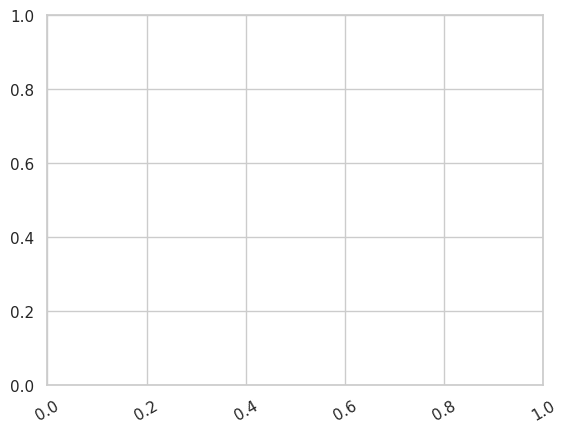

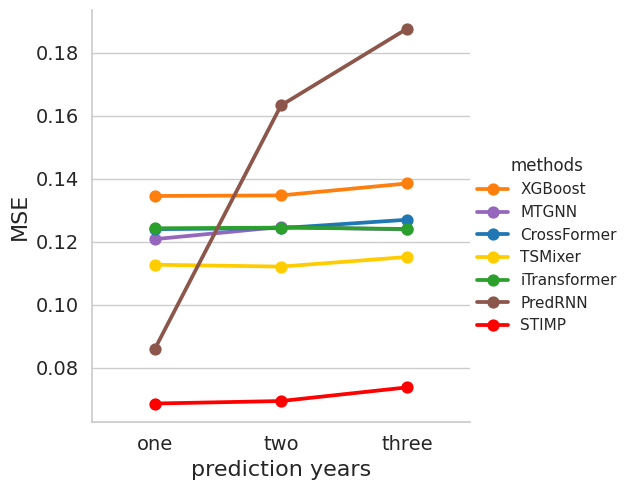

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = {'mse': np.concatenate(mse_list, axis=0),
        'methods':category,
        'prediction years':pred_len}
data = pd.DataFrame.from_dict(data)
sns.set(style="whitegrid")
plt.xticks(rotation=30)
color_palette = ["#FF0000", "#8C564B",  "#2CA02C", "#FFCC00", "#1F77B4", "#9467BD","#FF7F0E"][::-1]

g = sns.catplot(x="prediction years", y="mse", hue="methods", kind="point", data=data, palette=sns.color_palette(color_palette),ci=None)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("prediction years",fontsize=16)
plt.ylabel("MSE",fontsize=16)

Text(62.853375, 0.5, 'MAE')

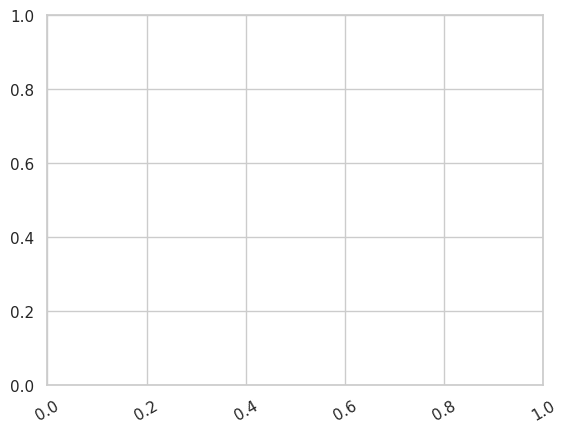

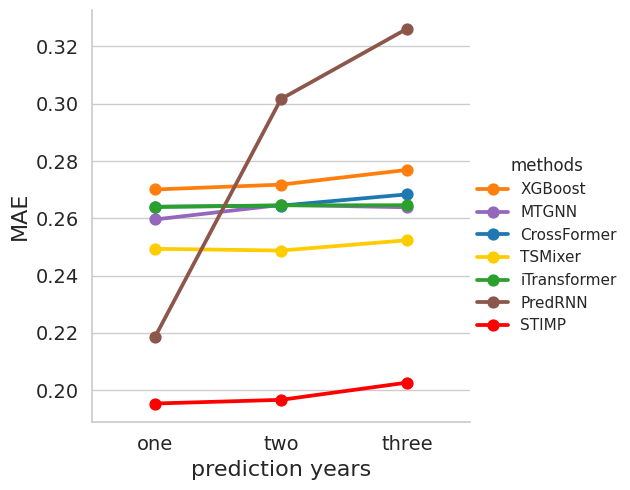

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = {'mae': np.concatenate(mae_list, axis=0),
        'methods':category,
        'prediction years':pred_len}
data = pd.DataFrame.from_dict(data)
sns.set(style="whitegrid")
plt.xticks(rotation=30)

g = sns.catplot(x="prediction years", y="mae", hue="methods", kind="point", data=data, palette=sns.color_palette(color_palette),ci=None)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("prediction years",fontsize=16)
plt.ylabel("MAE",fontsize=16)